In [2]:
# IMPORTS HERE
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from datetime import datetime

In [134]:
ticker = 'JPM.US'
interval = 'd'
url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file = ticker + '.csv'
urlretrieve(url, csv_file)
data = pd.read_csv(csv_file, index_col='Date', parse_dates=['Date'],
            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-02,160.02,161.6100,159.430,160.46,8815634.0
2021-09-03,160.39,160.8900,159.145,159.49,7961223.0
2021-09-07,159.99,161.3814,158.960,159.21,9290968.0
2021-09-08,158.89,159.5800,158.040,158.50,7852678.0
2021-09-09,158.27,160.8325,158.080,159.19,7904256.0


In [135]:
data = data.iloc[:, :-1]

<AxesSubplot:xlabel='Date'>

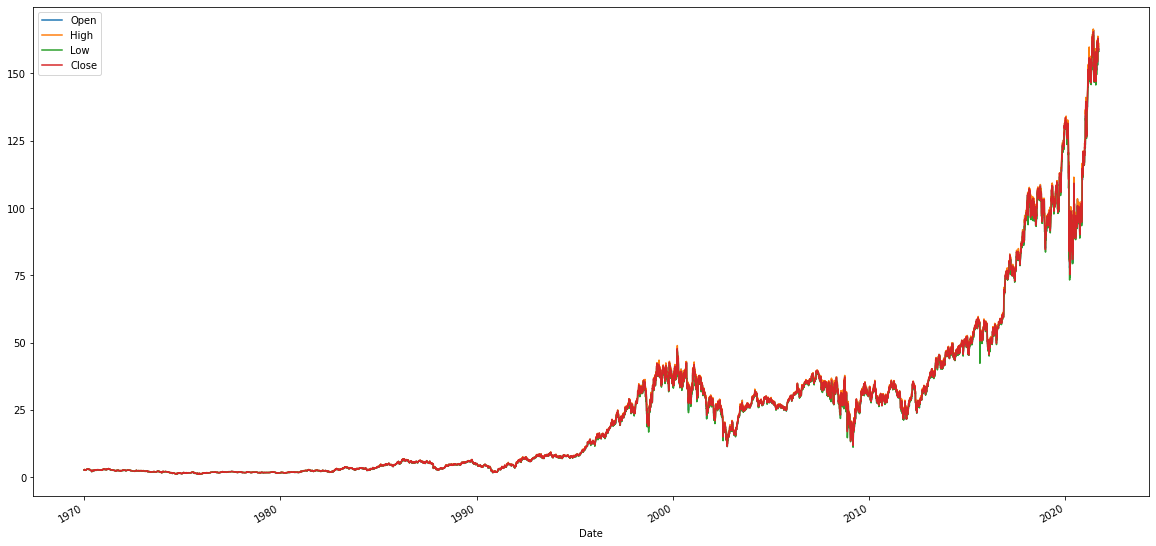

In [136]:
data.plot(figsize=(20,10))

# Creating returns

In [139]:
data['Returns'] = data.Close.pct_change(1)*100
data.head()

,Open,High,Low,Close,Returns
Date,,,,,
1970-01-02,2.8060,2.8060,2.7759,2.8060,NaN
1970-01-05,2.8060,2.8133,2.7835,2.8060,0.000000
1970-01-06,2.8060,2.8357,2.7909,2.8357,1.058446
1970-01-07,2.8433,2.9179,2.8433,2.9030,2.373312
1970-01-08,2.8955,2.8955,2.8584,2.8955,-0.258353


<AxesSubplot:xlabel='Date'>

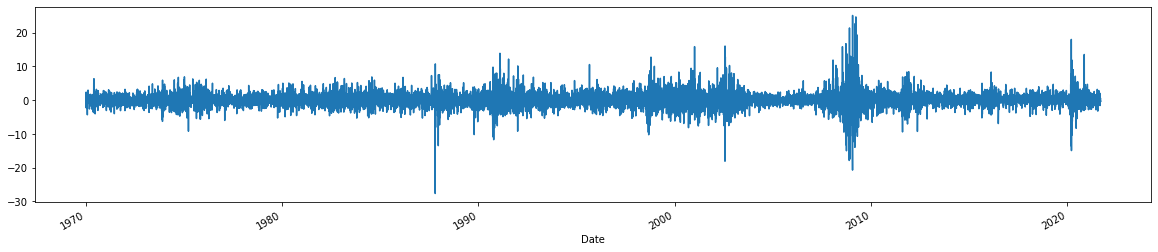

In [140]:
data['Returns'].plot(figsize=(20,4))

# Creating squared returns

In [141]:
data['sq_returns'] = data.Returns.mul(data.Returns)

<AxesSubplot:xlabel='Date'>

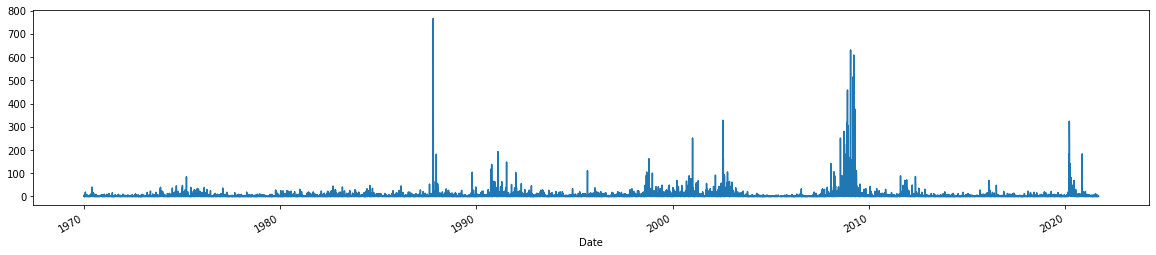

In [142]:
data['sq_returns'].plot(figsize=(20,4))

# Creating volatility (measured as standard deviation of logarithmic returns)

In [143]:
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))

# Computing Volatility using the pandas rolling standard deviation function
data['Volatility'] = data['Log_Ret'].rolling(window=252).std() * np.sqrt(252)
print(data.tail(15))

              Open      High       Low   Close   Returns  sq_returns  \
Date                                                                   
2021-08-19  153.16  155.5600  153.0100  154.28 -0.835583    0.698199   
2021-08-20  154.35  154.9000  153.1600  154.72  0.285196    0.081337   
2021-08-23  155.33  157.0900  155.2400  156.70  1.279731    1.637712   
2021-08-24  157.00  158.5500  156.8700  157.67  0.619017    0.383182   
2021-08-25  158.51  161.7800  157.8000  160.92  2.061267    4.248822   
2021-08-26  162.26  163.8300  161.1500  161.75  0.515784    0.266033   
2021-08-27  161.75  163.1600  161.2600  163.05  0.803709    0.645949   
2021-08-30  163.21  163.4900  159.8801  160.44 -1.600736    2.562356   
2021-08-31  160.44  161.3700  159.3500  159.95 -0.305410    0.093275   
2021-09-01  160.22  160.7600  158.9700  159.72 -0.143795    0.020677   
2021-09-02  160.02  161.6100  159.4300  160.46  0.463311    0.214657   
2021-09-03  160.39  160.8900  159.1450  159.49 -0.604512    0.36

<AxesSubplot:xlabel='Date'>

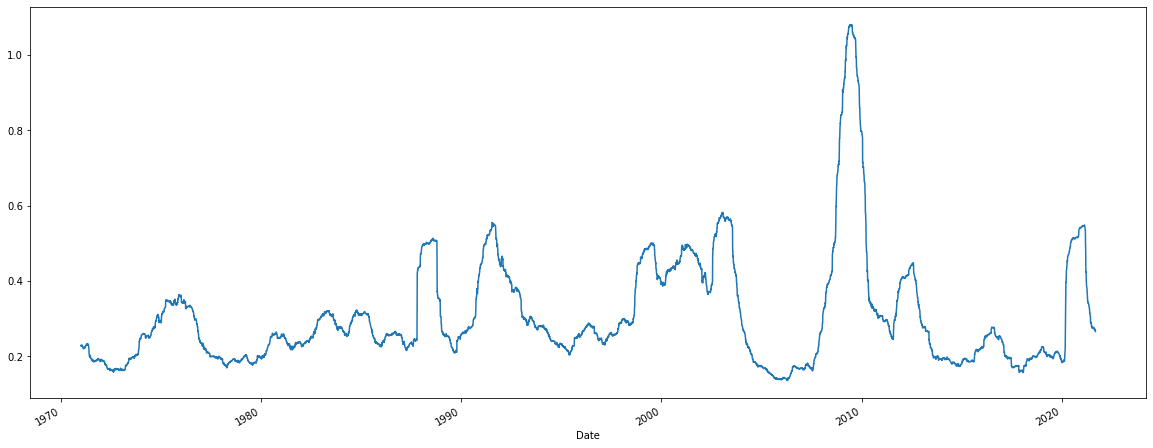

In [144]:
data['Volatility'].plot(figsize=(20,8))

# Train Test Split

In [149]:
df = data.drop(data.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)  # df.columns is zero-based pd.Index
df = df.iloc[252:]
df

,Volatility
Date,
1970-12-31,0.228474
1971-01-04,0.228706
1971-01-05,0.228486
1971-01-06,0.227500
1971-01-07,0.228727
...,...
2021-09-02,0.268903
2021-09-03,0.268973
2021-09-07,0.268284


In [150]:
size = 252
train, test = df.iloc[:-size], df.iloc[-size:]

# 252 - average trading days
#len(df) - 252

In [151]:
size

252

In [153]:
len(test)

252

In [154]:
train

,Volatility
Date,
1970-12-31,0.228474
1971-01-04,0.228706
1971-01-05,0.228486
1971-01-06,0.227500
1971-01-07,0.228727
...,...
2020-09-02,0.512842
2020-09-03,0.512353
2020-09-04,0.512805


In [155]:
test

,Volatility
Date,
2020-09-10,0.513425
2020-09-11,0.513547
2020-09-14,0.513349
2020-09-15,0.514224
2020-09-16,0.514229
...,...
2021-09-02,0.268903
2021-09-03,0.268973
2021-09-07,0.268284


# Scaling data - not necessary in CNN

In [156]:
# from sklearn.preprocessing import MinMaxScaler

In [157]:
# scaler = MinMaxScaler()

In [158]:
# scaler.fit(train)

In [159]:
# scaled_train = scaler.transform(train)
# scaled_test = scaler.transform(test)

# Defining a function that extracts features (lagged values) and outputs from the sequence

In [161]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Initializing Sequence, steps, and reshaping the output to input it to our CNN model.

In [162]:
# define input sequence
raw_seq = train['Volatility']
# choose a number of time steps and features
n_steps = size
n_features = 1

# split into samples
X, y = split_sequence(raw_seq, n_steps)
# # summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

# Create model

In [163]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU

In [164]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [165]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 251, 64)           192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                400050    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 400,293
Trainable params: 400,293
Non-trainable params: 0
_________________________________________________________________


In [166]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [167]:
X.shape

(12280, 252, 1)

# Training the model

In [168]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [169]:
model.fit(X, y, epochs=50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
307/307 [==============================] - 3s 10ms/step - loss: 0.0035 - val_loss: 3.6158e-04
Epoch 2/50
307/307 [==============================] - 3s 9ms/step - loss: 2.3532e-04 - val_loss: 2.5922e-04
Epoch 3/50
307/307 [==============================] - 3s 9ms/step - loss: 1.8868e-04 - val_loss: 2.3628e-04
Epoch 4/50
307/307 [==============================] - 3s 9ms/step - loss: 1.6468e-04 - val_loss: 1.3228e-04
Epoch 5/50
307/307 [==============================] - 3s 9ms/step - loss: 1.5951e-04 - val_loss: 1.2051e-04
Epoch 6/50
307/307 [==============================] - 3s 9ms/step - loss: 2.2016e-04 - val_loss: 1.2550e-04


In [170]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

### How loss function has been changing through epochs

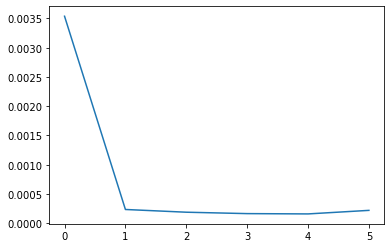

In [171]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Testing the model

In [172]:
first_eval_batch = train[-size:]
first_eval_batch = first_eval_batch['Volatility'].values
first_eval_batch

array([0.21123462, 0.21122487, 0.21178118, 0.21196044, 0.21202235,
       0.21222127, 0.21221744, 0.21035107, 0.21018299, 0.21049056,
       0.21033019, 0.21047132, 0.21019972, 0.21014498, 0.21045283,
       0.21137039, 0.21133182, 0.21219469, 0.21202688, 0.21315336,
       0.21318711, 0.21352968, 0.21239849, 0.21018276, 0.21189391,
       0.21181599, 0.21083838, 0.21057716, 0.2112935 , 0.21147942,
       0.21093968, 0.21064599, 0.209847  , 0.2093885 , 0.20887299,
       0.20857599, 0.20803696, 0.20816333, 0.20828837, 0.20819658,
       0.20811643, 0.20813607, 0.20751531, 0.20742549, 0.20726355,
       0.2061771 , 0.20611601, 0.20509343, 0.20380891, 0.20380652,
       0.20385256, 0.20261393, 0.20252044, 0.20230709, 0.20095789,
       0.20094152, 0.20070639, 0.20053617, 0.20078316, 0.20148209,
       0.19604174, 0.19546441, 0.19459153, 0.19354762, 0.19326171,
       0.19506638, 0.19533655, 0.19511482, 0.19464944, 0.1945656 ,
       0.19415121, 0.19389776, 0.19221536, 0.19077793, 0.18695

In [174]:
# a series of prediction

test_predictions = []

first_eval_batch = train[-size:]
first_eval_batch = first_eval_batch['Volatility'].values
current_batch = first_eval_batch.reshape((1, n_steps, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [175]:
test_predictions

[array([0.5129361], dtype=float32),
 array([0.5127882], dtype=float32),
 array([0.5126406], dtype=float32),
 array([0.51206225], dtype=float32),
 array([0.51131964], dtype=float32),
 array([0.51039875], dtype=float32),
 array([0.50969625], dtype=float32),
 array([0.5086813], dtype=float32),
 array([0.5079675], dtype=float32),
 array([0.50677466], dtype=float32),
 array([0.5059342], dtype=float32),
 array([0.5052555], dtype=float32),
 array([0.50458723], dtype=float32),
 array([0.5035778], dtype=float32),
 array([0.502528], dtype=float32),
 array([0.5010785], dtype=float32),
 array([0.4997525], dtype=float32),
 array([0.49910083], dtype=float32),
 array([0.49855158], dtype=float32),
 array([0.4967402], dtype=float32),
 array([0.49477595], dtype=float32),
 array([0.493597], dtype=float32),
 array([0.4930238], dtype=float32),
 array([0.4917859], dtype=float32),
 array([0.49047315], dtype=float32),
 array([0.4889166], dtype=float32),
 array([0.48747388], dtype=float32),
 array([0.4861792],

In [176]:
true_predictions = np.array(test_predictions)

In [177]:
test['Predictions'] = true_predictions

<ipython-input-177-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [178]:
test

,Volatility,Predictions
Date,,
2020-09-10,0.513425,0.512936
2020-09-11,0.513547,0.512788
2020-09-14,0.513349,0.512641
2020-09-15,0.514224,0.512062
2020-09-16,0.514229,0.511320
...,...,...
2021-09-02,0.268903,0.274203
2021-09-03,0.268973,0.273491
2021-09-07,0.268284,0.272747


<AxesSubplot:xlabel='Date'>

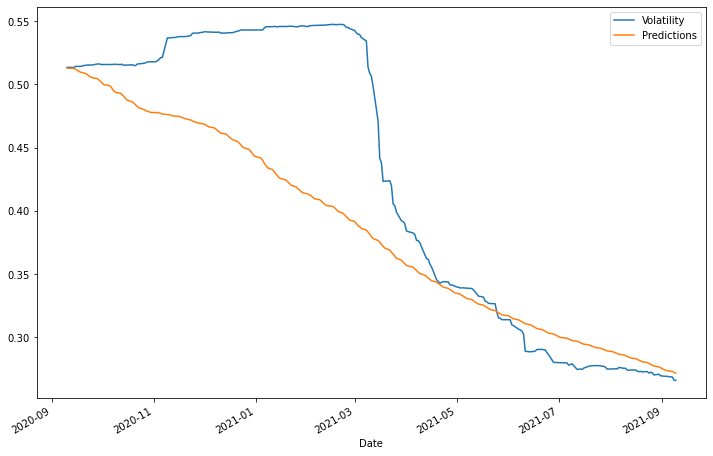

In [191]:
test.plot(figsize=(12,8))

In [186]:
    #MSE
    print(np.mean(np.square(test['Predictions'] - test['Volatility'])))
    #MAE
    print(np.mean(np.abs(test['Predictions'] - test['Volatility'])))
    #MAPE
    print(np.mean(np.abs((test['Volatility'] - test['Predictions']) / test['Volatility'])))

0.004618151377001137
0.0478376780185737
0.09767572089579629
